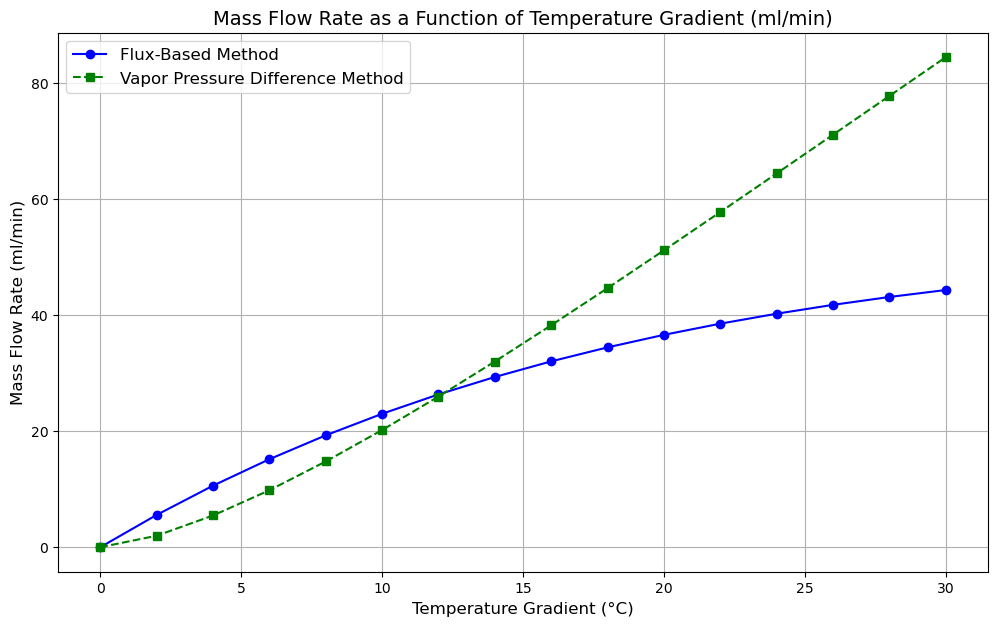

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
L_v = 2.5e6        # Latent heat of vaporization (J/kg)
R_v = 461.5        # Specific gas constant for water vapor (J/(kg·K))
R_air = 287        # Specific gas constant for dry air (J/(kg·K))
T_0 = 273.15       # Reference temperature (K)
e_0 = 611.2        # Reference vapor pressure at T_0 (Pa)
P_atm = 101325     # Atmospheric pressure (Pa)
D = 2.5e-5         # Diffusion coefficient for water vapor in air (m²/s)
lambda_layer = 0.004  # Boundary layer thickness (m)
g = 9.81           # Gravity (m/s²)
kappa = 2.2e-5     # Thermal diffusivity (m²/s)
nu = 1.5e-5        # Kinematic viscosity (m²/s)
rho_liquid = 1000  # Density of liquid water (kg/m³)

# Chamber dimensions
L = 3              # Side length (m)
H = 9              # Height (m)
A_b = L**2         # Bottom area (m²)
A_t = L**2         # Top area (m²)
A_s = 2 * H * L    # Total side area (m²)

# Saturation vapor pressure function
def saturation_vapor_pressure(T_celsius):
    T_kelvin = T_celsius + 273.15
    return e_0 * np.exp((L_v / R_v) * (1 / T_0 - 1 / T_kelvin))

# Function to calculate flux and mass flow rate
def calculate_flux_and_mass_flow(q_v, e_sat, T_wall, A, rho_a):
    T_wall_K = T_wall + 273.15
    qv_sat = e_sat / (rho_a * R_v * T_wall_K)
    J = (rho_a * D / lambda_layer) * (qv_sat - q_v)  # Flux (kg/m²*s)
    mdot = J * A  # Mass flow rate (kg/s)
    return J, mdot

# Calculate the convective mass transfer coefficient dynamically
def calculate_convective_mass_transfer_coefficient(delta_T, T_mean_K, D):
    beta = 1 / T_mean_K  # Thermal expansion coefficient
    Ra = (beta * g * H**3 * delta_T) / (kappa * nu)  # Rayleigh number
    Sc = nu / D  # Schmidt number
    Sh = 4.43e-4 * (Ra**0.5) * (Sc**0.5)  # Sherwood number
    h = (Sh * D) / H  # Convective mass transfer coefficient
    return h

# Method 1: Flux-Based Method (Updated with calculate_flux_and_mass_flow)
def calculate_mass_flow_with_flux(delta_T):
    T_b = 30  # Bottom wall temperature (C)
    T_t = T_b - delta_T  # Top wall temperature (C)

    T_s = T_b  # Side wall temperature (C)
    T_s_prime = T_t  # Opposite side wall temperature (C)

    # Calculate T_mean
    T_mean = (T_b + T_t + 2 * (H / L) * T_s + 2 * (H / L) * T_s_prime) / (2 + 4 * (H / L))
    T_mean_K = T_mean + 273.15

    # Air density
    rho_a = P_atm / (R_air * T_mean_K)

    # Saturation vapor pressures
    e_b = saturation_vapor_pressure(T_b)
    e_t = saturation_vapor_pressure(T_t)
    e_s = saturation_vapor_pressure(T_s)
    e_s_prime = saturation_vapor_pressure(T_s_prime)

    # Mixing ratio (q_v)
    q_v = (
        (e_b / (rho_a * R_v * (T_b + 273.15)) * A_b +
         e_t / (rho_a * R_v * (T_t + 273.15)) * A_t +
         2 * e_s / (rho_a * R_v * (T_s + 273.15)) * A_s +
         2 * e_s_prime / (rho_a * R_v * (T_s_prime + 273.15)) * A_s)
        / (A_b + A_t + 4 * A_s)
    )

    # Calculate fluxes and mass flow rates
    J_b, mdot_b = calculate_flux_and_mass_flow(q_v, e_b, T_b, A_b, rho_a)
    J_s, mdot_s = calculate_flux_and_mass_flow(q_v, e_s, T_s, A_s, rho_a)
    J_s_prime, mdot_s_prime = calculate_flux_and_mass_flow(q_v, e_s_prime, T_s_prime, A_s, rho_a)

    # Total mass flow rate
    mdot_total = mdot_b + 2 * mdot_s + 2 * mdot_s_prime

    return mdot_total

# Method 2: Vapor Pressure Difference Method
def calculate_mass_flow_with_vapor_pressure(delta_T):
    T_b = 30  # Bottom wall temperature (C)
    T_t = T_b - delta_T  # Top wall temperature (C)

    T_s = T_b  # Side wall temperature (C)
    T_s_prime = T_t  # Opposite side wall temperature (C)

    # Calculate T_mean
    T_mean = (T_b + T_t + 2 * (H / L) * T_s + 2 * (H / L) * T_s_prime) / (2 + 4 * (H / L))
    T_mean_K = T_mean + 273.15

    # Convective mass transfer coefficient
    h = calculate_convective_mass_transfer_coefficient(delta_T, T_mean_K, D)

    T_wall = T_s
    T_wall_K = T_wall + 273.15

    e_wall = saturation_vapor_pressure(T_wall)
    e_mean = saturation_vapor_pressure(T_mean)

    # Vapor pressure difference mass flow rate
    mdot = h * (e_wall / (R_v * T_wall_K) - e_mean / (R_v * T_mean_K)) * A_s
    return mdot

# Temperature gradient range
temperature_gradients = np.arange(0, 31, 2)

# Calculate mass flow rates for each method
mass_flow_rates_method1 = []
mass_flow_rates_method2 = []

for delta_T in temperature_gradients:
    # Method 1: Flux-Based
    mdot_method1 = calculate_mass_flow_with_flux(delta_T)
    mass_flow_rates_method1.append(mdot_method1)

    # Method 2: Vapor Pressure Difference
    mdot_method2 = calculate_mass_flow_with_vapor_pressure(delta_T)
    mass_flow_rates_method2.append(mdot_method2)

# Convert mass flow rates from kg/s to ml/min
mass_flow_rates_method1_ml_min = [mdot * 60 * 1000 for mdot in mass_flow_rates_method1]
mass_flow_rates_method2_ml_min = [mdot * 60 * 1000 for mdot in mass_flow_rates_method2]

# Plot
plt.figure(figsize=(12, 7))
plt.plot(temperature_gradients, mass_flow_rates_method1_ml_min, marker='o', linestyle='-', color='b', label='Flux-Based Method')
plt.plot(temperature_gradients, mass_flow_rates_method2_ml_min, marker='s', linestyle='--', color='g', label='Vapor Pressure Difference Method')
plt.xlabel('Temperature Gradient (°C)', fontsize=12)
plt.ylabel('Mass Flow Rate (ml/min)', fontsize=12)
plt.title('Mass Flow Rate as a Function of Temperature Gradient (ml/min)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()
